# Шаг 0. Введение

## Анализ продаж билетов и пользовательской активности (2024)

### Цель проекта
Провести аналитическое исследование данных о продажах билетов на мероприятия, чтобы:
- выявить ключевые тренды спроса и сезонности;
- понять особенности пользовательского поведения;
- определить наиболее значимые регионы, мероприятия и партнеров;
- проверить продуктовые гипотезы о различиях в активности пользователей мобильных и стационарных устройств;
- сформулировать практические рекомендации для продуктовой и бизнес-команд.

### Задачи исследования
В рамках проекта были поставлены следующие задачи:

1. Загрузить и подготовить данные к анализу
2. Провести исследовательский анализ данных (EDA)
4. Проанализировать регионы и билетных партнеров
5. Проверить статистические гипотезы
6. Сформулировать выводы и рекомендации на основе полученных результатов

### Описание данных
В анализе используются три датасета:

- **orders (final_tickets_orders_df.csv)** - данные о заказах билетов
- **events (final_tickets_events_df.csv)** - данные о мероприятиях
- **tenge_rates (final_tickets_tenge_df.csv)** - данные о курсе казахстанского тенге к рублю

### Структура проекта
1. Загрузка и первичное исследование данных  
2. Предобработка и создание новых признаков  
3. Исследовательский анализ и визуализация  
4. Статистический анализ и проверка гипотез  
5. Общий выводы и рекомендации  

### Дополнительная информация
Анализ проводится с фокусом на осенний период 2024 года, так как именно в этот период наблюдаются наиболее выраженные изменения пользовательской активности и спроса. Все выводы основаны на агрегированных данных и сопровождаются визуализациями и статистическими проверками.

# 1. Загрузка и первичное исследование данных

## 1.1. Импорт библиотек

In [1]:
# Установка seaborn при отсутствии в окружении
try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

## 1.2. Загрузка и первичный анализ данных

In [43]:
DATA_DIR = Path("data")

events = pd.read_csv(DATA_DIR / "events_sample.csv")
orders = pd.read_csv(DATA_DIR / "orders_sample.csv")
tenge = pd.read_csv(DATA_DIR / "tenge_sample.csv")

In [44]:
print(f"orders: {orders.shape}")
print(f"events: {events.shape}")
print(f"tenge: {tenge.shape}")

orders: (5000, 19)
events: (5000, 11)
tenge: (357, 4)


In [5]:
orders.info()
events.info()
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                5000 non-null   int64  
 1   user_id                 5000 non-null   object 
 2   created_dt_msk          5000 non-null   object 
 3   created_ts_msk          5000 non-null   object 
 4   event_id                5000 non-null   int64  
 5   cinema_circuit          5000 non-null   object 
 6   age_limit               5000 non-null   int64  
 7   currency_code           5000 non-null   object 
 8   device_type_canonical   5000 non-null   object 
 9   revenue                 5000 non-null   float64
 10  service_name            5000 non-null   object 
 11  tickets_count           5000 non-null   int64  
 12  total                   5000 non-null   float64
 13  days_since_prev         4623 non-null   float64
 14  curs                    5000 non-null   

In [6]:
orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,1029443,af26d5b5924d2f3,2024-10-11,2024-10-11 18:18:32,384539,нет,0,rub,mobile,52.33,Билеты без проблем,3,1308.33,0.0,19.8829,52.330002,17.443334,2024-10,осень
1,671177,02812f1183de24c,2024-10-01,2024-10-01 11:53:53,457197,нет,0,rub,mobile,192.25,Билеты в руки,4,3845.05,0.0,19.4525,192.250000,48.062500,2024-10,осень
2,5924904,9e01e5222f47f8c,2024-07-22,2024-07-22 22:57:16,365092,нет,16,rub,desktop,236.32,Билеты без проблем,3,3375.99,NaN,18.4518,236.320007,78.773336,2024-07,лето
3,5081381,4678368531a1efd,2024-06-08,2024-06-08 19:39:27,518819,нет,16,rub,mobile,686.87,Билеты без проблем,2,4292.95,0.0,19.8618,686.869995,343.434998,2024-06,лето
4,3834990,0beb8fc0c0a9ce1,2024-07-09,2024-07-09 13:57:18,175247,нет,16,rub,mobile,649.01,Билеты в руки,2,5900.10,0.0,18.5124,649.010010,324.505005,2024-07,лето


In [7]:
events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,555405,de78028d-0309-4dfa-9845-58f8969acb88,концерт,концерты,№3510,Боровлянский край,Каменский,63,2644,"Клуб китаристов ""Наследие"" Инкорпорэйтед","ул. Советская, д. 835 стр. 9"
1,523654,a1aaf5a7-6cdc-4ecf-973d-01d492c7d58c,спектакль,театр,№1074,Горностепной регион,Каменевовск,57,4318,"Школа сценического мастерства ""Палитра"" Инк","бул. Трудовой, д. 11 к. 4/1"
2,379721,63a64197-d94a-47e6-9432-f5edf8272ed3,концерт,концерты,№1874,Каменевский регион,Глиногорск,213,2304,"Творческое объединение ""Гармония"" Инк","наб. Партизанская, д. 47"
3,390166,26af7232-8d79-4c08-b7eb-609c370f6bfe,спортивное мероприятие,спорт,№1541,Каменевский регион,Глиногорск,213,1614,"Культурный центр ""Общие"" Групп","ул. Владимирская, д. 87 стр. 4"
4,414743,5ec58c69-2ade-45fe-aa32-3646a82f2380,шоу,стендап,№1288,Североярская область,Озёрск,2,986,"Гильдия художников ""Блюз"" Лтд","бул. Сосновый, д. 3 стр. 24"


In [8]:
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [9]:
orders.isna().mean().sort_values(ascending=False)

days_since_prev           0.0754
order_id                  0.0000
service_name              0.0000
month                     0.0000
one_ticket_revenue_rub    0.0000
revenue_rub               0.0000
curs                      0.0000
total                     0.0000
tickets_count             0.0000
revenue                   0.0000
user_id                   0.0000
device_type_canonical     0.0000
currency_code             0.0000
age_limit                 0.0000
cinema_circuit            0.0000
event_id                  0.0000
created_ts_msk            0.0000
created_dt_msk            0.0000
season                    0.0000
dtype: float64

In [10]:
events.isna().mean().sort_values(ascending=False)

event_id                  0.0
event_name                0.0
event_type_description    0.0
event_type_main           0.0
organizers                0.0
region_name               0.0
city_name                 0.0
city_id                   0.0
venue_id                  0.0
venue_name                0.0
venue_address             0.0
dtype: float64

In [11]:
tenge.isna().mean().sort_values(ascending=False)

data       0.0
nominal    0.0
curs       0.0
cdx        0.0
dtype: float64

In [12]:
orders['event_id'].isin(events['event_id']).mean()

0.2508

## 1.3. Вывод по этапу загрузки и первичного анализа данных

На первом этапе были загружены три датасета: данные о заказах билетов `orders`, информация о событиях `events` и справочник курсов валют `tenge`. Общий объем данных составляет около **290 тыс. заказов** и более **22 тыс. событий**, что является достаточным для проведения устойчивого аналитического исследования и построения дашбордов.

Структура всех датасетов полностью соответствует предоставленному описанию. Ключевые поля присутствуют, типы данных в целом корректны. Поля с датами `created_dt_msk`, `created_ts_msk` на данном этапе представлены строковым типом и требуют приведения к формату `datetime` на этапе предобработки.

Пропуски в данных практически отсутствуют. Единственное поле с заметной долей пропусков - `days_since_prev` (около 7,5%), что является ожидаемым и связано с первыми покупками пользователей. В таблицах `events` и `tenge` пропусков не обнаружено.

Проверка логической связности показала, что **более 99,9% заказов** корректно сопоставляются с событиями по `event_id`. Небольшая доля заказов без соответствующих событий не является критичной и может быть обработана на этапе объединения датасетов.

В данных представлены заказы в разных валютах, поэтому для дальнейшего анализа требуется приведение финансовых показателей к единой валюте (российские рубли) с использованием справочника курсов тенге.

Таким образом, данные можно считать качественными и готовыми к дальнейшей предобработке.

# 2. Предобработка и создание новых признаков

## 2.2. Предобработка категориальных признаков

In [13]:
print(
    'currency_code:\n', orders['currency_code'].value_counts(), '\n\n',
    'device_type_canonical:\n', orders['device_type_canonical'].value_counts(), '\n\n',
    'service_name (всего категорий):', orders['service_name'].nunique(), '\n',
    orders['service_name'].value_counts(), '\n\n',
    'cinema_circuit:\n', orders['cinema_circuit'].value_counts()
)

currency_code:
 currency_code
rub    4909
kzt      91
Name: count, dtype: int64 

 device_type_canonical:
 device_type_canonical
mobile     3956
desktop    1044
Name: count, dtype: int64 

 service_name (всего категорий): 31 
 service_name
Билеты без проблем        1077
Билеты в руки              713
Лови билет!                687
Мой билет                  613
Облачко                    472
Лучшие билеты              303
Весь в билетах             297
Прачечная                  151
Тебе билет!                108
Край билетов                99
Дом культуры                87
Яблоко                      87
За билетом!                 47
Городской дом культуры      45
Мир касс                    33
Show_ticket                 32
Быстробилет                 31
Выступления.ру              24
Восьмёрка                   23
Crazy ticket!               18
Радио ticket                11
Быстрый кассир               9
Росбилет                     7
Шоу начинается!              6
Телебилет       

In [14]:
print(
    'event_type_main:\n', events['event_type_main'].value_counts(), '\n\n',
    'region_name (всего регионов):', events['region_name'].nunique(), '\n',
    events['region_name'].value_counts(), '\n\n',
    'city_name (всего городов):', events['city_name'].nunique(), '\n',
    events['city_name'].value_counts()
)

event_type_main:
 event_type_main
концерты    1916
театр       1588
другое      1042
спорт        191
стендап      147
выставки      69
ёлки          47
Name: count, dtype: int64 

 region_name (всего регионов): 75 
 region_name
Каменевский регион       1320
Североярская область      869
Широковская область       262
Светополянский округ      208
Травяная область          163
                         ... 
Тихолесский край            1
Залесский край              1
Тихореченская область       1
Светолесский край           1
Крутоводский регион         1
Name: count, Length: 75, dtype: int64 

 city_name (всего городов): 222 
 city_name
Глиногорск      1267
Озёрск           868
Глиноград        157
Дальнесветск     150
Радужнополье     145
                ... 
Заречка            1
Карасуйск          1
Зареченец          1
Поленояр           1
Каменозолото       1
Name: count, Length: 222, dtype: int64


In [15]:
print(
    orders[['currency_code', 'device_type_canonical', 'service_name', 'cinema_circuit']].isna().mean(), '\n\n',
    events[['event_type_main', 'region_name', 'city_name']].isna().mean()
)

currency_code            0.0
device_type_canonical    0.0
service_name             0.0
cinema_circuit           0.0
dtype: float64 

 event_type_main    0.0
region_name        0.0
city_name          0.0
dtype: float64


In [16]:
orders['currency_code'] = orders['currency_code'].str.lower()
orders['device_type_canonical'] = orders['device_type_canonical'].str.lower()

In [17]:
print(
    orders['currency_code'].value_counts(), '\n\n',
    orders['device_type_canonical'].value_counts()
)

currency_code
rub    4909
kzt      91
Name: count, dtype: int64 

 device_type_canonical
mobile     3956
desktop    1044
Name: count, dtype: int64


**Вывод по предобработке категориальных признаков**

На этапе предобработки были изучены ключевые категориальные признаки в данных о заказах и событиях.

Явные пропуски в категориальных признаках отсутствуют. Значение `'нет'` в поле `cinema_circuit` встречается регулярно и обозначает отсутствие привязки к сети кинотеатров, поэтому оно не рассматривалось как пропуск и заменялось.

Значения в полях `currency_code` и `device_type_canonical` приведены к нижнему регистру (я забыл умное слово, для чего это делается, поэтому пусть будет "на всякий случай"). Остальные категориальные признаки (названия регионов, городов, операторов и мероприятий) сохранены без изменений, чтобы избежать искажения текстовых данных.

Таким образом, категориальные признаки не содержат ошибок и не требуют дополнительной чистки.

## 2.3. Анализ количественных признаков и выбросов

In [18]:
# Разделение данных по валютам
orders_rub = orders[orders['currency_code'] == 'rub']
orders_kzt = orders[orders['currency_code'] == 'kzt']

In [19]:
# Анализ tickets_count
orders_rub['tickets_count'].describe()

count    4909.000000
mean        2.745977
std         1.140696
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        11.000000
Name: tickets_count, dtype: float64

In [20]:
# Распределение (список)
orders_rub['tickets_count'].value_counts().sort_index()

tickets_count
1      698
2     1427
3     1570
4      923
5      228
6       61
9        1
11       1
Name: count, dtype: int64

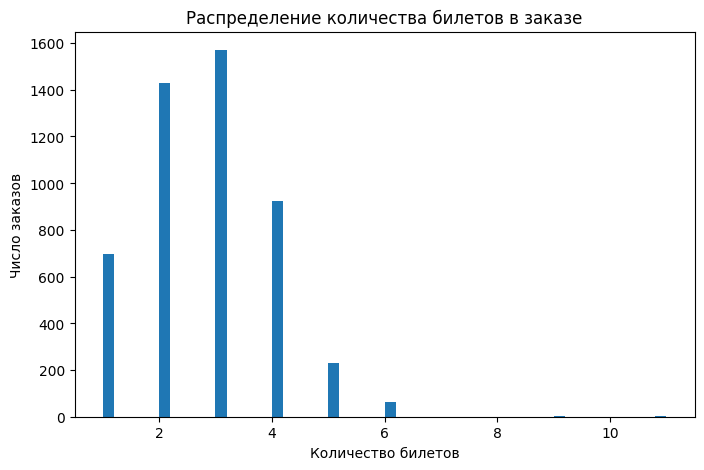

In [21]:
# Распределение (гистограмма)
plt.figure(figsize=(8, 5))
orders_rub['tickets_count'].hist(bins=50)

plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Число заказов')

plt.grid(False)
plt.show()

In [22]:
# Анализ revenue (RUB)
# Распределение (список)
orders_rub['revenue'].describe(percentiles=[0.95, 0.99])

count     4909.000000
mean       563.580933
std       1035.947574
min         -3.590000
50%        340.490000
95%       1636.096000
99%       2594.440000
max      48704.720000
Name: revenue, dtype: float64

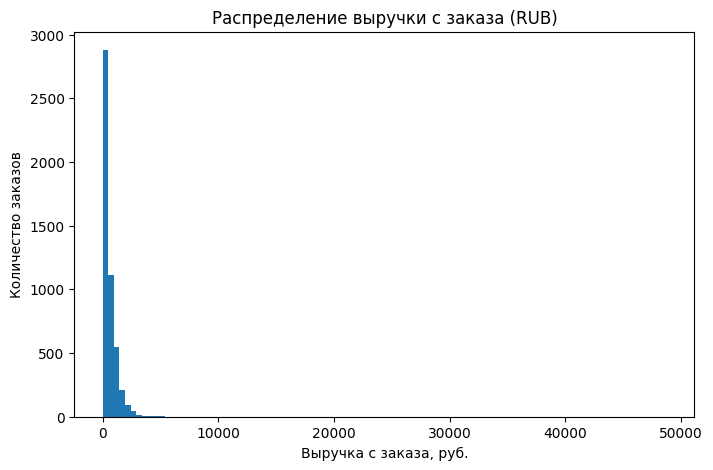

In [23]:
# Распределение (гистограмма)
plt.figure(figsize=(8, 5))
orders_rub['revenue'].hist(bins=100)

plt.title('Распределение выручки с заказа (RUB)')
plt.xlabel('Выручка с заказа, руб.')
plt.ylabel('Количество заказов')

plt.grid(False)
plt.show()

In [24]:
# Отсечение выбросов по 99-му процентилю
revenue_99 = orders_rub['revenue'].quantile(0.99)
orders_rub_clean = orders_rub[orders_rub['revenue'] <= revenue_99]
orders_rub_clean['revenue'].describe(percentiles=[0.95, 0.99])

count    4860.000000
mean      516.853735
std       514.039446
min        -3.590000
50%       336.115000
95%      1571.087500
99%      2131.670000
max      2594.440000
Name: revenue, dtype: float64

In [25]:
# Анализ revenue (KZT)
# Распределение (список)
orders_kzt['revenue'].describe(percentiles=[0.95, 0.99])

count       91.000000
mean      5436.395934
std       4655.785207
min         65.910000
50%       5548.240000
95%      13784.260000
99%      17617.240000
max      17617.240000
Name: revenue, dtype: float64

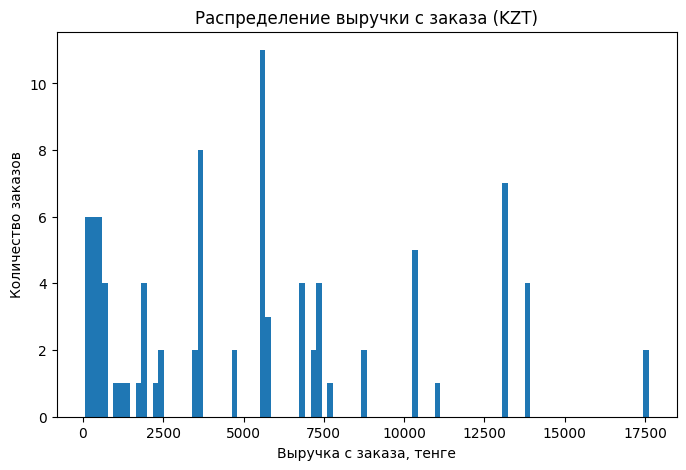

In [26]:
# Распределение (гистограмма)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

orders_kzt['revenue'].hist(bins=100)

plt.title('Распределение выручки с заказа (KZT)')
plt.xlabel('Выручка с заказа, тенге')
plt.ylabel('Количество заказов')

plt.grid(False)
plt.show()

**Вывод по анализу количественных признаков и выбросов**

На данном этапе был выполнен анализ количественных показателей `revenue` и `tickets_count`. В соответствии с заданием анализ проводился отдельно для заказов в рублях и тенге.

Распределение количества билетов в заказе `tickets_count` характеризуется концентрацией значений в диапазоне 1-4 билета. Более высокие значения встречаются редко и логически объясняются групповыми покупками, поэтому данный показатель не подвергался очистке от выбросов.

Распределение выручки с заказа `revenue` имеет выраженную правостороннюю асимметрию и длинный хвост, что указывает на наличие выбросов. Для анализа распределений была выполнена фильтрация значений `revenue` по 99-му процентилю для заказов в рублях. Аналогичный анализ проведен отдельно для заказов в тенге.

При этом выбросы не удалялись из исходных данных: очищенная версия использовалась только для анализа распределений, тогда как агрегированные метрики рассчитываются по полному датасету.

Таким образом, количественные признаки не содержат аномалий, требующих исключения данных, а выявленные выбросы были корректно учтены в рамках анализа.

## 2.4. Проверка явных и неявных дубликатов

In [27]:
# Явные дубликаты
orders.duplicated().mean()

0.0

In [28]:
# Проверка уникальности order_id
orders['order_id'].nunique() == len(orders)

True

In [29]:
# Неявные дубликаты бронирований
dubl = orders[orders.duplicated(
    subset=['user_id','event_id','created_dt_msk','tickets_count','revenue'],
    keep=False
)].sort_values(['user_id','event_id','created_dt_msk']).head(10)

dubl

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,curs,revenue_rub,one_ticket_revenue_rub,month,season
2857,6907627,043ad5de015a5d2,2024-09-03,2024-09-03 11:19:48,564990,нет,0,rub,mobile,155.72,Билеты в руки,4,3892.98,0.0,18.6868,155.720001,38.930000,2024-09,осень
3161,6907685,043ad5de015a5d2,2024-09-03,2024-09-03 11:15:44,564990,нет,0,rub,mobile,155.72,Билеты в руки,4,3892.98,0.0,18.6868,155.720001,38.930000,2024-09,осень
4276,6908265,043ad5de015a5d2,2024-09-03,2024-09-03 11:17:55,564990,нет,0,rub,mobile,155.72,Билеты в руки,4,3892.98,0.0,18.6868,155.720001,38.930000,2024-09,осень
606,1734607,043f669c9f734b1,2024-10-01,2024-10-01 11:37:46,574431,нет,0,rub,mobile,155.99,Билеты в руки,4,3899.74,0.0,19.4525,155.990005,38.997501,2024-10,осень
1979,1734549,043f669c9f734b1,2024-10-01,2024-10-01 11:23:10,574431,нет,0,rub,mobile,155.99,Билеты в руки,4,3899.74,0.0,19.4525,155.990005,38.997501,2024-10,осень
320,921911,086a3a0a69f5075,2024-09-14,2024-09-14 07:54:51,506746,нет,18,rub,mobile,1208.54,Облачко,4,10986.72,0.0,19.0586,1208.540039,302.135010,2024-09,осень
2033,921940,086a3a0a69f5075,2024-09-14,2024-09-14 08:34:01,506746,нет,18,rub,mobile,1208.54,Облачко,4,10986.72,0.0,19.0586,1208.540039,302.135010,2024-09,осень
4797,921969,086a3a0a69f5075,2024-09-14,2024-09-14 11:06:42,506746,нет,18,rub,mobile,1208.54,Облачко,4,10986.72,0.0,19.0586,1208.540039,302.135010,2024-09,осень
637,2532774,0ae42a8c1d07049,2024-09-20,2024-09-20 23:07:17,573343,нет,12,rub,mobile,23.34,Билеты без проблем,1,466.81,0.0,19.3536,23.340000,23.340000,2024-09,осень
1784,2534398,0ae42a8c1d07049,2024-09-20,2024-09-20 15:56:15,573343,нет,12,rub,mobile,23.34,Билеты без проблем,1,466.81,0.0,19.3536,23.340000,23.340000,2024-09,осень


In [30]:
orders.duplicated(subset=dubl.columns, keep=False).mean()

0.0

**Вывод по проверке явных и неявных дубликатов**

На данном этапе была выполнена проверка данных о заказах на наличие явных и неявных дубликатов.

Проверка явных дубликатов (полное совпадение строк) показала, что их в датасете нет: доля полностью дублирующихся записей равна 0. Дополнительно подтверждено, что идентификатор заказа `order_id` является уникальным для всех строк, что исключает наличие технических дублей заказов.

Далее была проведена проверка на неявные дубликаты бронирований без учета идентификатора заказа. В качестве критериев использовались совпадения по пользователю `user_id`, мероприятию `event_id`, дате создания заказа `created_dt_msk`, количеству билетов `tickets_count` и выручке `revenue`. В результате были выявлены группы заказов с совпадающими бизнес-признаками.

Детальный просмотр таких записей показал, что они имеют разные `order_id` и различаются временем создания `created_ts_msk`. Это указывает на последовательное оформление нескольких заказов одним пользователем, а не на ошибочное дублирование данных.

В рамках анализа было принято решение **не удалять выявленные неявные дубликаты**, так как они соответствуют реальным транзакциям и их исключение привело бы к искажению показателей выручки и количества заказов.

Таким образом, датасет не содержит критических дубликатов, требующих очистки.

## 2.5. Преобразования типов данных

In [31]:
orders['created_dt_msk'] = pd.to_datetime(orders['created_dt_msk'])
orders['created_ts_msk'] = pd.to_datetime(orders['created_ts_msk'])

In [32]:
orders[['created_dt_msk', 'created_ts_msk']].dtypes

created_dt_msk    datetime64[ns]
created_ts_msk    datetime64[ns]
dtype: object

In [33]:
tenge['data'] = pd.to_datetime(tenge['data'])

In [34]:
tenge['data'].dtype

dtype('<M8[ns]')

In [35]:
orders.dtypes

order_id                           int64
user_id                           object
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int64
cinema_circuit                    object
age_limit                          int64
currency_code                     object
device_type_canonical             object
revenue                          float64
service_name                      object
tickets_count                      int64
total                            float64
days_since_prev                  float64
curs                             float64
revenue_rub                      float64
one_ticket_revenue_rub           float64
month                             object
season                            object
dtype: object

In [36]:
tenge.dtypes

data       datetime64[ns]
nominal             int64
curs              float64
cdx                object
dtype: object

In [37]:
orders.memory_usage(deep=True).sum() / 1024**2

3.2538442611694336

In [38]:
# Сэкономим немного памяти
orders['age_limit'] = orders['age_limit'].astype('int8')
orders['tickets_count'] = orders['tickets_count'].astype('int16')
orders['event_id'] = orders['event_id'].astype('int32')
orders['revenue'] = orders['revenue'].astype('float32')
orders['total'] = orders['total'].astype('float32')

In [39]:
orders.memory_usage(deep=True).sum() / 1024**2

3.1346349716186523

**Вывод по преобразованию типов данных**

На данном этапе были выполнены преобразования типов данных с целью корректной работы с временными признаками и оптимизации использования памяти.

Поля с датой и временем `created_dt_msk`, `created_ts_msk` были приведены к формату `datetime`, что позволяет корректно выполнять временные агрегации, сортировку и фильтрацию данных. Аналогичное преобразование выполнено для поля даты в справочнике валютных курсов.

Для количественных признаков была проведена оптимизация типов данных. Целочисленные поля с ограниченным диапазоном значений `age_limit`, `tickets_count` приведены к более компактным типам. Идентификатор мероприятия `event_id` приведен к типу `int32`. Финансовые показатели `revenue`, `total` приведены к типу `float32`, что позволяет снизить потребление памяти без потери точности, критичной для анализа.

Строковые признаки и идентификаторы заказов не подвергались дополнительной оптимизации, так как это не является критичным для текущего этапа анализа и может усложнить дальнейшую обработку данных.

## 2.6. Создание новых столбцов

In [40]:
# Подготовка курса
tenge_2024 = (tenge.loc[tenge['cdx'] == 'kzt', ['data', 'curs']].rename(columns={'data': 'created_dt_msk'}))

In [41]:
# Джоин курса к заказам
orders = orders.merge(tenge_2024, on='created_dt_msk', how='left')

In [42]:
# Расчет revenue_rub
orders['revenue_rub'] = orders['revenue'].astype('float64')

mask_kzt = orders['currency_code'] == 'kzt'
orders.loc[mask_kzt, 'revenue_rub'] = (
    orders.loc[mask_kzt, 'revenue'] * orders.loc[mask_kzt, 'curs'] / 100
)

KeyError: 'curs'

In [ ]:
# Выручка одного билета one_ticket_revenue_rub
orders['one_ticket_revenue_rub'] = (
    orders['revenue_rub'] / orders['tickets_count']
)

In [ ]:
# Месяц заказа month
orders['month'] = orders['created_dt_msk'].dt.month

In [ ]:
# Сезонность season
orders['season'] = 'осень'

orders.loc[orders['month'].isin([12, 1, 2]), 'season'] = 'зима'
orders.loc[orders['month'].isin([3, 4, 5]), 'season'] = 'весна'
orders.loc[orders['month'].isin([6, 7, 8]), 'season'] = 'лето'

In [ ]:
# Проверка результата
orders[['currency_code', 'revenue', 'revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']].head()

In [ ]:
# Проверка результата (только для заказов в тенге)
orders.loc[
    orders['currency_code'] == 'kzt',
    ['currency_code', 'revenue', 'curs', 'revenue_rub', 'tickets_count', 'one_ticket_revenue_rub', 'month', 'season']
].head(10)

## 2.7. Вывод по этапу предобработки данных

### Объем данных
- **Заказы `orders`**: 290 849 строк × 14 столбцов  
- **События `events`**: 22 427 строк × 11 столбцов  
- **Курсы валют `tenge`**: 357 строк × 4 столбца  

Фильтрация строк на данном этапе **не применялась**, количество наблюдений сохранено.

---

### Качество данных
- Пропуски обнаружены только в столбце `days_since_prev` (около 7,5%), что ожидаемо для первой покупки пользователя.
- Явные дубликаты заказов отсутствуют (`order_id` уникален).
- Обнаружены **неявные дубликаты бронирований** (одинаковые `user_id`, `event_id`, `created_dt_msk`, `tickets_count`, `revenue`), что может отражать повторные попытки бронирования. Эти строки сохранены для дальнейшего анализа.

---

### Преобразования типов и оптимизация памяти
- Даты и время приведены к типу `datetime64[ns]`:
  - `created_dt_msk`
  - `created_ts_msk`
  - `tenge['data']`
- Числовые столбцы приведены к более компактным типам (`int8`, `int16`, `int32`, `float32`).
- Потребление памяти таблицы `orders` снижено примерно с **136 МБ до 129 МБ**.

---

### Созданные новые столбцы
- **`revenue_rub`** - выручка заказа, приведенная к рублям:  
  - для `rub` - без изменений;  
  - для `kzt` - пересчет по курсу из датасета `tenge` (`curs / 100`).
- **`one_ticket_revenue_rub`** - средняя выручка с одного билета.
- **`month`** - месяц оформления заказа.
- **`season`** - сезон (`зима`, `весна`, `лето`, `осень`).

Корректность конвертации валют подтверждена проверками.

---

### Итог
Данные очищены, приведены к корректным типам и оптимизированы по памяти. Также добавлены новые столбцы, применимые в будущих исследованиях.
Датасет готов к этапу исследовательского анализа.

# 3. Исследовательский анализ и визуализация

## 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

### 3.1.1. Распределение по месяцам

In [ ]:
# Подготовка данных для анализа по месяцам
orders['month'] = orders['created_dt_msk'].dt.to_period('M').astype(str)
orders['month'].sort_values().unique()

In [ ]:
# Общая динамика заказов по месяцам
monthly_orders = (
    orders
    .groupby('month', as_index=False)
    .agg(total_orders=('order_id', 'count'))
)

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(monthly_orders['month'], monthly_orders['total_orders'], marker='o')
plt.title('Динамика количества заказов по месяцам')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.show()

In [ ]:
orders_events = orders.merge(
    events[['event_id', 'event_type_main']],
    on='event_id',
    how='left'
)

In [ ]:
orders_events[['event_id', 'event_type_main']].head()

In [ ]:
# Сезонность по типу мероприятия (event_type_main)
monthly_by_event = (
    orders_events
        .groupby(['month', 'event_type_main'], as_index=False)
        .agg(total_orders=('order_id', 'count'))
)

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_by_event,
    x='month',
    y='total_orders',
    hue='event_type_main',
    marker='o',
    palette='tab10'
)
plt.title('Сезонная динамика заказов по типу мероприятия')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(title='Тип мероприятия')
plt.grid(axis='y')
plt.show()

In [ ]:
# Сезонность по типу устройства (device_type_canonical)
monthly_by_device = (
    orders
    .groupby(['month', 'device_type_canonical'], as_index=False)
    .agg(total_orders=('order_id', 'count'))
)

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_by_device,
    x='month',
    y='total_orders',
    hue='device_type_canonical',
    marker='o',
    palette='tab10'
)
plt.title('Сезонная динамика заказов по типу устройства')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(title='Тип устройства')
plt.grid(axis='y')
plt.show()

In [ ]:
# Сезонность по возрастному рейтингу (age_limit)
monthly_by_age = (
    orders
    .groupby(['month', 'age_limit'], as_index=False)
    .agg(total_orders=('order_id', 'count'))
)

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_by_age,
    x='month',
    y='total_orders',
    hue='age_limit',
    marker='o',
    palette='tab10'
)
plt.title('Сезонная динамика заказов по возрастному рейтингу')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(title='Рейтинг')
plt.grid(axis='y')
plt.show()

### 3.1.2. Выводы по динамике заказов по месяцам

#### Общая динамика
Анализ помесячной динамики показал выраженный рост количества заказов в период с июня по октябрь 2024 года. Наиболее заметное ускорение роста наблюдается с августа, а пик активности приходится на сентябрь-октябрь. Это подтверждает наличие **осенней сезонности пользовательского спроса**, ранее выявленной на уровне дашборда.

---

#### Динамика по типу мероприятия
Рост заказов в осенний период наблюдается по всем основным типам мероприятий, однако его интенсивность различается:
- **Концерты** демонстрируют наиболее выраженный рост и формируют основной вклад в общее увеличение заказов осенью.
- **Театральные мероприятия** также показывают значительное увеличение спроса, особенно начиная с сентября.
- Категории **"другое"** и **"спорт"** растут более умеренно, но сохраняют положительную динамику.
- Менее массовые категории (выставки, стендап, елки) демонстрируют рост, однако их вклад в общий объем заказов остается ограниченным.

Это указывает на то, что осенняя сезонность в первую очередь связана с ростом интереса к культурно-развлекательным мероприятиям, таким как концерты и театр.

---

#### Динамика по типу устройства
Во всех месяцах доминирует **мобильный канал**, и именно он обеспечивает основной вклад в рост заказов осенью:
- Количество заказов с мобильных устройств растет быстрее, чем с десктопа.
- Десктопный канал также показывает рост, однако его доля остается существенно ниже.

Таким образом, осенний рост пользовательской активности происходит преимущественно за счет мобильных пользователей, что указывает на устойчивость мобильного сценария покупки билетов.

---

#### Динамика по возрастному рейтингу
Рост заказов в осенний период характерен для всех возрастных категорий, однако наиболее выражен:
- для мероприятий с рейтингами **12+ и 16+**, которые демонстрируют резкий рост начиная с сентября;
- для категории **0+**, что может быть связано с расширением досуговой активности семейной аудитории осенью.

Категория **18+** растет более плавно и остается наименее массовой, что говорит о более стабильном, но ограниченном спросе в этом сегменте.

---

#### Итоговое заключение
Осенняя сезонность в данных выражается не только в общем росте количества заказов, но и в изменении структуры пользовательского спроса. Основными драйверами осеннего роста являются концерты и театральные мероприятия, а также мобильный канал продаж. Наиболее активно реагируют на сезонный фактор аудитории мероприятий с возрастными рейтингами 12+ и 16+. Полученные результаты подтверждают наличие устойчивой сезонной компоненты пользовательского интереса в осенний период.


### 3.1.3. Распределение по сезонам

In [ ]:
orders_season = orders[orders['season'].isin(['лето', 'осень'])].copy()

In [ ]:
orders_season['season'].value_counts()

In [ ]:
orders_evt = orders_season.merge(
    events[['event_id', 'event_type_main']],
    on='event_id',
    how='left'
)

In [ ]:
# Распределение по типу мероприятия
event_share = (
    orders_evt
    .groupby(['season', 'event_type_main'], as_index=False)
    .agg(orders_cnt=('order_id', 'count'))
)

event_share['share'] = (
    event_share['orders_cnt'] /
    event_share.groupby('season')['orders_cnt'].transform('sum')
)

In [ ]:
plt.figure(figsize=(13, 6))
sns.barplot(
    data=event_share,
    x='event_type_main',
    y='share',
    hue='season',
    palette='tab10'
)
plt.title('Распределение по типу мероприятия: лето / осень')
plt.ylabel('Доля заказов')
plt.xlabel('')
plt.legend(title='Сезон')
plt.grid(axis='y')
plt.show()

In [ ]:
# Распределение по типу устройства
device_share = (
    orders_season
    .groupby(['season', 'device_type_canonical'], as_index=False)
    .agg(orders_cnt=('order_id', 'count'))
)

device_share['share'] = (
    device_share['orders_cnt'] /
    device_share.groupby('season')['orders_cnt'].transform('sum')
)

In [ ]:
plt.figure(figsize=(13, 6))
sns.barplot(
    data=device_share,
    x='device_type_canonical',
    y='share',
    hue='season',
    palette='tab10'
)
plt.title('Распределение по типу устройства: лето / осень')
plt.ylabel('Доля заказов')
plt.xlabel('')
plt.legend(title='Сезон')
plt.grid(axis='y')
plt.show()

In [ ]:
# Распределение по возрастному рейтингу
age_share = (
    orders_season
    .groupby(['season', 'age_limit'], as_index=False)
    .agg(orders_cnt=('order_id', 'count'))
)

age_share['share'] = (
    age_share['orders_cnt'] /
    age_share.groupby('season')['orders_cnt'].transform('sum')
)

In [ ]:
plt.figure(figsize=(13, 6))
sns.barplot(
    data=age_share,
    x='age_limit',
    y='share',
    hue='season',
    palette='tab10'
)
plt.title('Распределение заказов по возрастному рейтингу: лето / осень')
plt.ylabel('Доля заказов')
plt.xlabel('')
plt.legend(title='Сезон')
plt.grid(axis='y')
plt.show()

### 3.1.4. Выводы по сезонному распределению

#### Тип мероприятия
- **Концерты** остаются крупнейшей категорией в оба сезона, однако их доля **снижается осенью** по сравнению с летом.
- **Театр** и **спорт** демонстрируют **рост доли осенью**, что указывает на усиление интереса к более "офлайн-ориентированным" и регулярным форматам мероприятий.
- Категория **"другое"** заметно теряет долю осенью, что может быть связано с перераспределением спроса в пользу более конкретных и привычных типов событий.
- Нишевые категории (**выставки**, **елки**, **стендап**) занимают небольшую долю в оба сезона и не оказывают существенного влияния на общую структуру заказов.

#### Тип устройства
- В обоих сезонах **мобильные устройства доминируют** и формируют около 80% всех заказов.
- Осенью доля мобильных заказов **незначительно снижается**, при этом доля заказов с **desktop слегка растет**, что может быть связано с более осознанным планированием мероприятий в осенний период.

#### Возрастной рейтинг
- Наибольшая доля заказов в обоих сезонах приходится на мероприятия с рейтингом **16+** - это ключевая аудитория сервиса.
- Осенью увеличивается доля мероприятий с рейтингами **0+** и **12+**, что может говорить о росте семейной и массовой аудитории.
- Доля мероприятий **18+ заметно снижается осенью**, что указывает на более умеренное поведение пользователей и смещение спроса к универсальному контенту.

#### Общий вывод
При переходе от лета к осени наблюдается не только рост общего количества заказов, но и **структурные изменения спроса**. Пользователи чаще выбирают театральные и спортивные мероприятия, немного чаще оформляют заказы с desktop-устройств и смещаются в сторону более массовых и семейных форматов по возрастному рейтингу. Это подтверждает наличие сезонных паттернов пользовательского интереса, которые важно учитывать при планировании ассортимента и маркетинговых активностей.

In [ ]:
# Средняя выручка с 1 билета по типу мероприятия и сезону
avg_ticket_by_event = (
    orders_evt
    .groupby(['event_type_main', 'season'], as_index=False)
    .agg(avg_one_ticket_revenue=('one_ticket_revenue_rub', 'mean'))
)

# Таблица "лето / осень"
pivot_event_price = (
    avg_ticket_by_event
    .pivot(index='event_type_main', columns='season', values='avg_one_ticket_revenue')
    .reset_index()
)

pivot_event_price = pivot_event_price.rename_axis(None, axis=1)

# Относительное изменение осени к лету (в %)
pivot_event_price['relative_change_pct'] = (
    (pivot_event_price['осень'] - pivot_event_price['лето']) / pivot_event_price['лето'] * 100
)

pivot_event_price

In [ ]:
values = pivot_event_price['relative_change_pct']

colors = ['tab:green' if v > 0 else 'tab:red' for v in values]

plt.figure(figsize=(10, 5))
bars = plt.bar(pivot_event_price['event_type_main'], values, color=colors)

plt.axhline(0)
plt.title('Относительное изменение средней цены билета осенью по сравнению с летом')
plt.xlabel('Тип мероприятия')
plt.ylabel('Изменение, %')

plt.tight_layout()
plt.show()

### 3.1.5. Итоговый вывод по сезонным изменениям (лето -> осень)

С наступлением осени распределение заказов по категориям мероприятий меняется, что отражает как сдвиг пользовательского интереса, так и особенности ценообразования.

**Распределение заказов:**
- Осенью усиливается концентрация заказов в **концертах** и **театре** - эти категории остаются ключевыми драйверами спроса.
- Доля **спорта** и **театра** увеличивается, что характерно для осеннего сезона.
- Доля категории **"другое"** снижается, что говорит о перераспределении спроса в более конкретные форматы мероприятий.
- **Выставки** и **елки** занимают небольшую долю и остаются нишевыми категориями, однако демонстрируют устойчивое присутствие.

**Средняя стоимость одного билета:**
- Изменение средней стоимости билета **не является однородным** по всем типам мероприятий.
- Рост средней цены осенью зафиксирован у:
  - **стендапа**;
  - **выставок**.
- Снижение средней стоимости билета наблюдается у:
  - **театра**, **концертов**, **елок**, **спорта** и категории **"другое"**.

**Общий вывод:**
Осенний рост общего количества заказов сопровождается перераспределением спроса между категориями. При этом увеличение объема заказов не всегда ведет к росту средней цены билета: в большинстве категорий осенью билеты в среднем дешевле, за исключением отдельных форматов с более платежеспособной или лояльной аудиторией.

## 3.2. Осенняя активность пользователей

In [ ]:
# Оставляем только осень 2024
orders_autumn = orders[orders['season'] == 'осень'].copy()

orders_autumn['date'] = orders_autumn['created_dt_msk'].dt.date

In [ ]:
# Одна сводная таблица по дням
daily_metrics = (
    orders_autumn
    .groupby('date')
    .agg(
        orders_cnt=('order_id', 'count'),
        dau=('user_id', 'nunique'),
        avg_ticket_price=('one_ticket_revenue_rub', 'mean')
    )
    .reset_index()
)

daily_metrics['orders_per_user'] = (
    daily_metrics['orders_cnt'] / daily_metrics['dau']
)

In [ ]:
# Линейные графики
fig, axs = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

axs[0].plot(daily_metrics['date'], daily_metrics['orders_cnt'])
axs[0].set_title('Количество заказов (DAILY)')

axs[1].plot(daily_metrics['date'], daily_metrics['dau'])
axs[1].set_title('DAU')

axs[2].plot(daily_metrics['date'], daily_metrics['orders_per_user'])
axs[2].set_title('Заказов на пользователя')

axs[3].plot(daily_metrics['date'], daily_metrics['avg_ticket_price'])
axs[3].set_title('Средняя стоимость билета')

plt.tight_layout()
plt.show()

In [ ]:
# Недельная цикличность (будни / выходные)
daily_metrics['weekday'] = pd.to_datetime(daily_metrics['date']).dt.weekday
daily_metrics['day_type'] = daily_metrics['weekday'].apply(
    lambda x: 'выходной' if x >= 5 else 'будний'
)

weekly_pattern = (
    daily_metrics
    .groupby('day_type')
    .agg(
        avg_orders=('orders_cnt', 'mean'),
        avg_dau=('dau', 'mean'),
        avg_orders_per_user=('orders_per_user', 'mean'),
        avg_ticket_price=('avg_ticket_price', 'mean')
    )
)

weekly_pattern

### Промежуточный вывод: пользовательская активность осенью 2024 года

**1. Дневная динамика**
- **Количество заказов** и **DAU** демонстрируют общий восходящий тренд в течение осеннего периода, что указывает на рост пользовательской активности.
- Наблюдаются отдельные **резкие пики** (в начале и середине периода), которые сопровождаются ростом как числа заказов, так и DAU - вероятно, влияние крупных событий, акций или релизов.
- **Среднее число заказов на пользователя** в целом стабильно, с кратковременными всплесками в дни пикового спроса.
- **Средняя стоимость билета** колеблется без выраженного тренда: после резких отклонений возвращается к уровню 180-210 руб., что говорит об отсутствии устойчивого роста цен в динамике.

**2. Недельная цикличность (будни / выходные)**
- В **будние дни**:
  - больше заказов (=2933 / =2419);
  - выше DAU (=943 / =894);
  - больше заказов на пользователя (=3.07 / =2.69).
- В **выходные дни**:
  - ниже объем активности, но
  - **выше средняя стоимость билета** (=205 руб. / =190 руб.).

**3. Итог**
- Осенью 2024 года рост активности обеспечивается преимущественно **увеличением числа активных пользователей**, а не ростом среднего чека.
- Будни формируют основной объем заказов, тогда как выходные характеризуются **более дорогими покупками** при меньшей частоте заказов.
- Выраженная недельная цикличность подтверждает различия в пользовательском поведении между буднями и выходными.

##  3.3. Популярные события и партнеры

In [ ]:
orders_full = orders.merge(
    events[['event_id', 'region_name']],
    on='event_id',
    how='left'
)

In [ ]:
region_stats = (
    orders_full
    .groupby('region_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'count'),
        total_revenue=('revenue_rub', 'sum')
    )
    .sort_values('total_revenue', ascending=False)
)

In [ ]:
region_stats.head(10)

In [ ]:
region_stats['events_share'] = (region_stats['unique_events'] / region_stats['unique_events'].sum())

region_stats['orders_share'] = (region_stats['total_orders'] / region_stats['total_orders'].sum())

region_stats['revenue_share'] = (region_stats['total_revenue'] / region_stats['total_revenue'].sum())

In [ ]:
region_stats.sort_values('unique_events', ascending=False).head(10)

In [ ]:
partner_stats = (
    orders_full
    .groupby('service_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'count'),
        total_revenue=('revenue_rub', 'sum')
    )
    .sort_values('total_revenue', ascending=False)
)

In [ ]:
partner_stats.head(10)

In [ ]:
partner_stats['orders_share'] = (partner_stats['total_orders'] / partner_stats['total_orders'].sum())

partner_stats['revenue_share'] = (partner_stats['total_revenue'] / partner_stats['total_revenue'].sum())

In [ ]:
partner_stats[['orders_share', 'revenue_share']].head(5).sum()

In [ ]:
region_stats.head(10)['total_revenue'].plot(
    kind='barh',
    figsize=(13, 6),
    title='Топ-10 регионов по выручке'
)

In [ ]:
partner_stats.head(10)['total_revenue'].plot(
    kind='barh',
    figsize=(8, 5),
    title='Топ-10 билетных партнеров по выручке'
)

### Промежуточный вывод: популярные регионы и билетные партнеры

**Распределение по регионам**

- Наблюдается ярко выраженный лидер - **Каменевский регион**:
  - максимальная выручка (= 61 млн),
  - наибольшее число заказов (= 91 тыс.),
  - самый широкий ассортимент мероприятий (= 6 тыс. уникальных событий).
  Он формирует около **38% общей выручки** и более **31% всех заказов**, что указывает на высокую концентрацию спроса.

- **Североярская область** занимает второе место по всем ключевым метрикам, но существенно уступает лидеру:
  - ~17% мероприятий,
  - ~15% заказов,
  - ~16% выручки.

- Остальные регионы имеют значительно меньшие доли (как правило, <6% по каждому показателю), что говорит о **сильной асимметрии распределения**: рынок сконцентрирован в нескольких ключевых регионах.

- Разнообразие мероприятий (unique_events) в целом коррелирует с выручкой и числом заказов: регионы с большим числом событий, как правило, зарабатывают больше.

**Билетные партнеры**

- Явные лидеры по выручке:
  - **"Билеты без проблем"** - крупнейший партнер по всем метрикам (выручка, заказы, уникальные мероприятия),
  - **"Мой билет"** и **"Облачко"** - второй эшелон с сопоставимыми объемами выручки.

- При этом:
  - некоторые партнеры (например, **"Лови билет!"**) обрабатывают большое число заказов, но имеют более низкую среднюю выручку на заказ,
  - другие (например, **"Край билетов"**) работают с меньшим количеством заказов, но заметно меньшей долей рынка.

**Общий вывод**

- И среди регионов, и среди партнеров присутствуют **четко выраженные лидеры**, формирующие значительную долю выручки и заказов.
- Распределение неравномерное: рынок опирается на ограниченное число ключевых регионов и партнеров.
- Это создает потенциал для:
  - масштабирования успешных моделей лидеров,
  - целевого развития регионов и партнеров второго эшелона для снижения концентрационных рисков.

# 4. Статистический анализ и проверка гипотез

In [ ]:
# --- Фильтрация данных (только осень, mobile и desktop)
autumn = orders[
    (orders['season'] == 'осень') &
    (orders['device_type_canonical'].isin(['mobile', 'desktop']))
].copy()

# --- Гипотеза 1: заказы на пользователя

# Cчитаем количество заказов на пользователя
orders_per_user = (
    autumn
    .groupby(['user_id', 'device_type_canonical'], as_index=False)
    .agg(orders_cnt=('order_id', 'count'))
)

mobile_orders = orders_per_user.loc[
    orders_per_user['device_type_canonical'] == 'mobile',
    'orders_cnt'
]

desktop_orders = orders_per_user.loc[
    orders_per_user['device_type_canonical'] == 'desktop',
    'orders_cnt'
]

# Mann–Whitney U (односторонняя: mobile > desktop)
u1, p1 = mannwhitneyu(
    mobile_orders,
    desktop_orders,
    alternative='greater'
)

print('Гипотеза 1: заказы на пользователя')
print('mobile: mean=', mobile_orders.mean(), 'median=', mobile_orders.median())
print('desktop: mean=', desktop_orders.mean(), 'median=', desktop_orders.median())
print('p-value =', p1)
print('-' * 50)


# --- Гипотеза 2: время между заказами

# берем только валидные интервалы
intervals = autumn.dropna(subset=['days_since_prev']).copy()

# среднее время между заказами на пользователя
days_per_user = (
    intervals
    .groupby(['user_id', 'device_type_canonical'], as_index=False)
    .agg(avg_days_between=('days_since_prev', 'mean'))
)

mobile_days = days_per_user.loc[
    days_per_user['device_type_canonical'] == 'mobile',
    'avg_days_between'
]

desktop_days = days_per_user.loc[
    days_per_user['device_type_canonical'] == 'desktop',
    'avg_days_between'
]

# Mann–Whitney U (односторонний: mobile > desktop)
u2, p2 = mannwhitneyu(
    mobile_days,
    desktop_days,
    alternative='greater'
)

print('Гипотеза 2: время между заказами')
print('mobile: mean=', mobile_days.mean(), 'median=', mobile_days.median())
print('desktop: mean=', desktop_days.mean(), 'median=', desktop_days.median())
print('p-value =', p2)
print('-' * 50)

**Вывод по проверке гипотез (осень 2024)**

В данном разделе проверялись гипотезы о различиях в активности пользователей мобильных и стационарных устройств **в осенний период 2024 года**.  
Для анализа использовались независимые выборки пользователей, разделённые по типу устройства (`mobile` и `desktop`).

---

**Выбор статистического теста**

Для проверки гипотез применен **U-критерий Манна-Уитни**, так как:

- сравниваются **две независимые выборки** пользователей;
- распределения показателей асимметричны и содержат выбросы;
- объёмы выборок велики, но нормальность распределений не гарантирована.

Использовался **односторонний тест**, так как гипотезы предполагают направленное различие.

---

**Гипотеза 1. Заказы на одного пользователя**

**H0 (нулевая гипотеза):**  
Среднее количество заказов на одного пользователя мобильных устройств **не выше**, чем у пользователей стационарных устройств.

**H1 (альтернативная гипотеза):**  
Среднее количество заказов на одного пользователя **выше у мобильных пользователей**, чем у пользователей desktop.

**Результат:**  
- mobile: среднее = 9.52, медиана = 2  
- desktop: среднее = 7.07, медиана = 2  
- p-value = 1.3e-07  

Нулевая гипотеза отвергается. Различие статистически значимо.

---

**Гипотеза 2. Время между заказами**

**H0 (нулевая гипотеза):**  
Среднее время между заказами у мобильных пользователей **не больше**, чем у пользователей стационарных устройств.

**H1 (альтернативная гипотеза):**  
Среднее время между заказами **больше у мобильных пользователей**, чем у desktop.

**Результат:**  
- mobile: среднее = 20.66 дня, медиана = 9.5  
- desktop: среднее = 14.96 дня, медиана ≈ 4.62  
- p-value = 1.3e-51  

Нулевая гипотеза отвергается. Различие статистически значимо.

---

1. **Заказы на пользователя.**  
   Пользователи мобильных устройств оформляют больше заказов, чем пользователи стационарных устройств. Различия статистически значимы (p-value < 0.05).

2. **Время между заказами.**  
   У пользователей мобильных устройств среднее время между заказами выше, чем у пользователей стационарных устройств. Различия статистически значимы (p-value < 0.05).

Обе гипотезы подтверждены данными.

# 5. Общий вывод и рекомендации

## Общий вывод и рекомендации

### Данные
В проекте были проанализированы данные о заказах билетов за 2024 год, включающие информацию о заказах (дата, выручка, количество билетов, тип устройства), событиях (тип мероприятия, возрастной рейтинг, регион, площадка) и курсах валют для приведения выручки к единой валюте - рублю. Общий объем данных - около 290 тыс. заказов, что позволяет делать статистически обоснованные выводы.

### Основные результаты анализа

- **Наиболее востребованные мероприятия**  
  Лидерами по количеству заказов и выручке являются *концерты* и *театр*. Эти категории формируют основную долю спроса на протяжении всего периода.

- **Сезонность и осенние изменения**  
  Осенью наблюдается рост общего числа заказов по сравнению с летним периодом. При этом структура спроса частично меняется:
  - увеличивается доля театра и спортивных мероприятий;
  - снижается доля концертов и некоторых нишевых категорий.
  
- **Средняя стоимость билета**  
  Средняя выручка с одного билета осенью по большинству категорий снижается или остается стабильной, что может указывать на:
  - рост промо-активностей;
  - увеличение массовых и более доступных мероприятий;
  - смещение спроса в сторону мероприятий с более низкой ценой билета.

- **Пользовательская активность**  
  Осенью 2024 года наблюдается рост:
  - ежедневного числа заказов;
  - DAU;
  - среднего числа заказов на пользователя.  
  При этом будние дни характеризуются более высокой активностью, чем выходные, тогда как средняя цена билета на выходных выше.

- **Регионы и партнеры**  
  Существует выраженная концентрация выручки:
  - один регион-лидер формирует значительную долю всех заказов и выручки;
  - среди билетных партнеров также выделяется несколько явных лидеров, аккумулирующих основную часть оборота.  
  Распределение неравномерное, «длинный хвост» регионов и партнеров дает небольшой вклад.

### Проверка гипотез

- Пользователи **мобильных устройств**:
  - совершают больше заказов на одного пользователя;
  - имеют большее среднее время между заказами.
- Различия между мобильными и стационарными пользователями статистически значимы (p-value значительно < 0.05), что подтверждает более высокую вовлеченность мобильной аудитории.

### Итоговые рекомендации

1. **Сфокусироваться на мобильной аудитории**  
   Усилить развитие мобильного приложения и мобильных сценариев покупки - это наиболее активный и ценный сегмент.

2. **Учитывать сезонность при планировании**  
   Осенний рост спроса стоит использовать для:
   - расширения ассортимента мероприятий;
   - запуска целевых маркетинговых кампаний.

3. **Работать с лидерами регионов и партнеров**  
   Углублять сотрудничество с ключевыми регионами и билетными партнерами, одновременно анализируя потенциал роста менее развитых сегментов.

4. **Оптимизировать ценовую стратегию**  
   Снижение средней стоимости билета осенью может быть использовано для привлечения новой аудитории, но требует контроля маржинальности.

В целом данные указывают на устойчивый рост пользовательской активности осенью и ключевую роль мобильного канала, что должно стать приоритетом в продуктовых и маркетинговых решениях.